In [1]:
import sys
sys.path.append('/auto/users/hellerc/code/projects/nat_pupil_ms/')
sys.path.append('/home/charlie/lbhb/code/projects/nat_pup_ms/')
from path_settings import DPRIME_DIR, PY_FIGURES_DIR2, CACHE_PATH
from global_settings import ALL_SITES, LOWR_SITES, HIGHR_SITES, CPN_SITES
import charlieTools.nat_sounds_ms.decoding as decoding
import load_results as ld
import nems.db as nd
import charlieTools.nat_sounds_ms.preprocessing as nat_preproc

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os

[nems.configs.defaults INFO] Saving log messages to /tmp/nems/NEMS 2021-09-27 090304.log


### Compare batch 289 and batch 331
* Is diversity in dprime real? i.e. is there something that explains it? Or is it due to between site variability?

In [5]:
# Load decoding results for both batches and for two models (factor analysis noise vs. delta nc noise)
path = DPRIME_DIR
loader = decoding.DecodingResults()
recache = False
sites = CPN_SITES #+ HIGHR_SITES
batches = [331]*len(CPN_SITES) #+ [289]*len(HIGHR_SITES)
modelname1 = 'dprime_jk10_zscore_nclvz_fixtdr2-fa'
modelname2 = 'dprime_jk10_zscore_nclvz_fixtdr2-nclv'
modelname1 = 'dprime_jk10_zscore_fixtdr2-fa'
modelname2 = 'dprime_jk10_zscore_fixtdr2-fa'
#modelname = 'dprime_jk10_zscore_fixtdr2-fa_rmlowFR-4'
ndim1 = 2
ndim2 = 2

df = []
df_lv = []
for i, (batch, site) in enumerate(zip(batches, sites)):
    
    for mn, ddf, ndim in zip([modelname1, modelname2], [df, df_lv], [ndim1, ndim2]):
        if site in ['BOL005c', 'BOL006b']:
            batch = 294
        try:
            fn = os.path.join(path, str(batch), site, mn+'_TDR.pickle')
            results = loader.load_results(fn, cache_path=None, recache=recache)
            _df = results.numeric_results
        except:
            print(f"WARNING!! NOT LOADING SITE {site}")
            #raise ValueError(f"WARNING!! NOT LOADING SITE {site}")

        stim = results.evoked_stimulus_pairs
        _df = _df.loc[pd.IndexSlice[stim, ndim], :]
        _df['site'] = site
        _df['batch'] = batch
        _df['sp_noise_mag'] = results.array_results['sp_evals'].loc[pd.IndexSlice[stim, ndim], 'mean'].apply(lambda x: x.sum())
        _df['bp_noise_mag'] = results.array_results['bp_evals'].loc[pd.IndexSlice[stim, ndim], 'mean'].apply(lambda x: x.sum())
        _df['noise_alignment'] = results.slice_array_results('cos_dU_evec_test', stim, ndim, idx=(0,0))[0]
        _df['delta_mu'] = results.slice_array_results('dU_all', stim, ndim, idx=(0,))[0]
        _df['delta_mu'] = _df['delta_mu'].apply(lambda x: x / np.linalg.norm(x))
        
        # add epoch names back to dataframe
        _df['epoch1'] = [results.mapping[k][0] for k in _df.index.get_level_values(0)]
        _df['epoch2'] = [results.mapping[k][1] for k in _df.index.get_level_values(0)]

        ddf.append(_df)

# model 1
df = pd.concat(df)
df['delta_noise'] = (df['sp_noise_mag'] - df['bp_noise_mag']) / (df['sp_noise_mag'] + df['bp_noise_mag'])
df['delta_dprime'] = (df['bp_dp'] - df['sp_dp']) / (df['bp_dp'] + df['sp_dp'])

# model 2
df_lv = pd.concat(df_lv)
df_lv['delta_noise'] = (df_lv['sp_noise_mag'] - df_lv['bp_noise_mag']) / (df_lv['sp_noise_mag'] + df_lv['bp_noise_mag'])
df_lv['delta_dprime'] = (df_lv['bp_dp'] - df_lv['sp_dp']) / (df_lv['bp_dp'] + df_lv['sp_dp'])

[root INFO] loading pickle from /auto/users/hellerc/results/nat_pupil_ms/dprime_final/331/AMT020a/dprime_jk10_zscore_fixtdr2-fa_TDR.pickle
[root INFO] loading pickle from /auto/users/hellerc/results/nat_pupil_ms/dprime_final/331/AMT020a/dprime_jk10_zscore_fixtdr2-fa_TDR.pickle
[root INFO] loading pickle from /auto/users/hellerc/results/nat_pupil_ms/dprime_final/331/AMT026a/dprime_jk10_zscore_fixtdr2-fa_TDR.pickle
[root INFO] loading pickle from /auto/users/hellerc/results/nat_pupil_ms/dprime_final/331/AMT026a/dprime_jk10_zscore_fixtdr2-fa_TDR.pickle
[root INFO] loading pickle from /auto/users/hellerc/results/nat_pupil_ms/dprime_final/331/ARM029a/dprime_jk10_zscore_fixtdr2-fa_TDR.pickle
[root INFO] loading pickle from /auto/users/hellerc/results/nat_pupil_ms/dprime_final/331/ARM029a/dprime_jk10_zscore_fixtdr2-fa_TDR.pickle
[root INFO] loading pickle from /auto/users/hellerc/results/nat_pupil_ms/dprime_final/331/ARM031a/dprime_jk10_zscore_fixtdr2-fa_TDR.pickle
[root INFO] loading pickle 

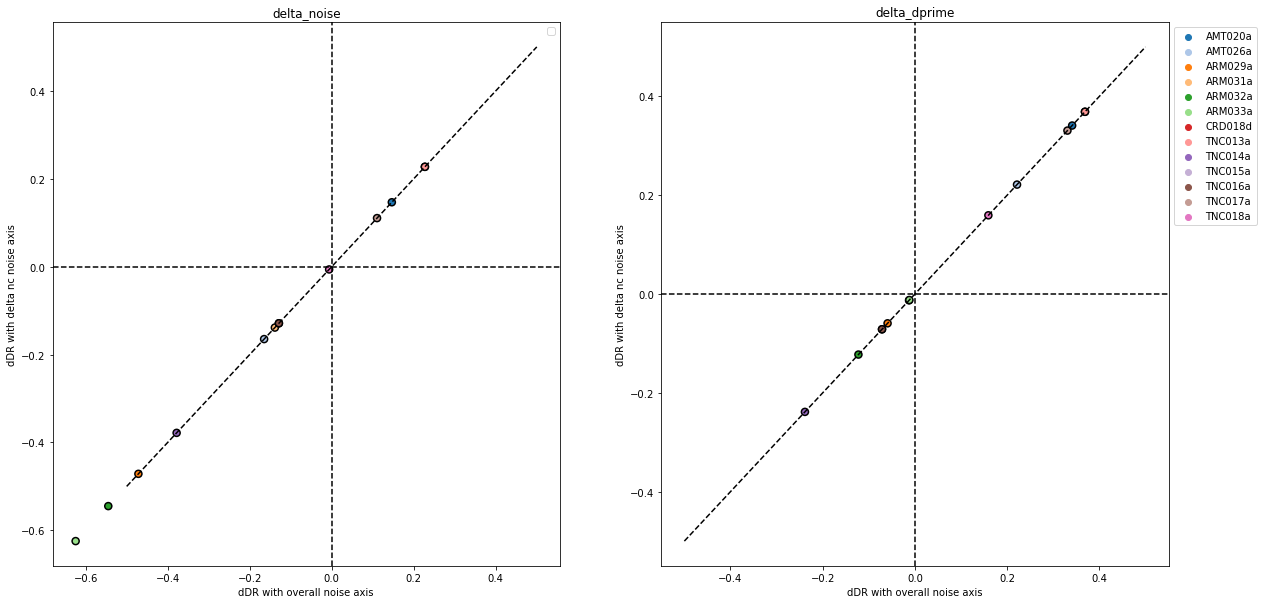

In [6]:
feature1 = 'delta_noise'
feature2 = 'delta_dprime'
f, ax = plt.subplots(1, 2, figsize=(20, 10))
if 1:
    for feature, a in zip([feature1, feature2], [ax[0], ax[1]]):
        bmask = df.batch==289
        sns.scatterplot(df[bmask].groupby(by=['site']).mean()[feature], 
                        df_lv[bmask].groupby(by=['site']).mean()[feature], 
                        hue=df[bmask].groupby(by=['site']).mean().index.get_level_values(0), ax=a, palette='tab20', **{'s':75})
        bmask = df.batch==331
        sns.scatterplot(df[bmask].groupby(by=['site']).mean()[feature], 
                        df_lv[bmask].groupby(by=['site']).mean()[feature], 
                        hue=df[bmask].groupby(by=['site']).mean().index.get_level_values(0), ax=a, palette='tab20', **{'s':50, 'edgecolor': 'k', 'linewidth': 1.5})
        a.plot([-0.5, 0.5], [-0.5, 0.5], 'k--')
else:
    for feature, a in zip([feature1, feature2], [ax[0], ax[1]]):
        ridx = np.random.choice(range(df.shape[0]), 2000)
        sns.scatterplot(df.iloc[ridx][feature], df_lv.iloc[ridx][feature], hue=df.iloc[ridx]['site'], ax=a, palette='tab20', **{'s':15})
        a.plot([-1, 1], [-1, 1], 'k--')

for feature, a in zip([feature1, feature2], [ax[0], ax[1]]):    
    a.axhline(0, linestyle='--', color='k')
    a.axvline(0, linestyle='--', color='k')
    a.set_title(feature)
    a.set_xlabel('dDR with overall noise axis')
    a.set_ylabel('dDR with delta nc noise axis')
ax[0].legend([])
ax[1].legend(bbox_to_anchor=(1, 1), loc='upper left')

In [8]:
f, ax = plt.subplots(1, 1, figsize=(12, 6))

bins = np.arange(0, 90, 1)
for site in df.site.unique():
    if site in CPN_SITES:
        col = 'orange'
    else:
        col = 'purple'
    sns.kdeplot(x=(np.arccos(df_lv[df_lv.site==site]['beta2_dot_dU']) * 180 / np.pi), label=site, color=col, lw=2)

ax.set_xlabel("Angle (deg) betwen delta nc axis and delta mu")
ax.legend(bbox_to_anchor=(1, 1), loc='upper left')

KeyError: 'beta2_dot_dU'

In [115]:
x = np.random.normal(0, 1, 2)
x /= np.linalg.norm(x)

theta1 = np.arccos(np.abs(x.dot([0, 1]))) * 180 / np.pi
theta2 = np.arccos(np.abs(x.dot([1, 0]))) * 180 / np.pi
print(theta1+theta2)

89.99999999999999
